In [1]:
import h5py
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
import sys
import shutil
import glob
import optparse
import os
import json
import pandas as pd
import numpy as np
import pylab as pl
import scipy.stats as stats
import seaborn as sns
sys.path.append('/n/coxfs01/cechavarria/repos/2p-pipeline/')

In [2]:
class struct: pass

optsE = struct()
optsE.rootdir = '/n/coxfs01/2p-data'
optsE.animalid = 'JC097'
optsE.session = '20190705'
optsE.acquisition = 'FOV1_zoom4p0x'
traceid = 'traces001_s2p'
run = 'scenes_combined'


#% Set up paths:    
acquisition_dir = os.path.join(optsE.rootdir, optsE.animalid, optsE.session, optsE.acquisition)
if 'combined' in run:
    traceid_dir = os.path.join(acquisition_dir, run,'traces',traceid)
else:
    traceid_dir = util.get_traceid_from_acquisition(acquisition_dir, run, traceid)
run_dir = traceid_dir.split('/traces')[0]
trace_arrays_dir = os.path.join(traceid_dir,'files')
paradigm_dir = os.path.join(acquisition_dir, run, 'paradigm')


responses_dir = os.path.join(acquisition_dir, run,'responses',traceid)
data_array_dir = os.path.join(responses_dir, 'data_arrays')

    
if not os.path.exists(os.path.join(responses_dir,'figures')):
    os.makedirs(os.path.join(responses_dir,'figures'))

In [3]:
#open_tilf
resp_array_fn = 'trial_response_array.hdf5'
resp_array_filepath = os.path.join(data_array_dir,'files' , resp_array_fn)
resp_grp = h5py.File(resp_array_filepath, 'r')

if 's2p_cell_rois' in resp_grp.attrs.keys():
    cell_rois = resp_grp.attrs['s2p_cell_rois']
else:
    cell_rois = np.arange(nrois)
config_img = resp_grp.attrs['config_img'].astype('int')
config_cond = resp_grp.attrs['config_cond'].astype('int')

curr_slice = 'Slice01'#hard,coding for now

#unpack
response_matrix_zscore = np.array(resp_grp['/'.join([curr_slice, 'responses' ,'zscore'])])
response_matrix_df_f = np.array(resp_grp['/'.join([curr_slice, 'responses' ,'df_f'])])

#consider only cell ROIs
zscore_matrix = response_matrix_zscore[:,:,cell_rois]
response_matrix = response_matrix_df_f[:,:,cell_rois]
ntrials, nstims, nrois = response_matrix.shape

In [67]:
half1.shape

(30, 30, 134)

In [6]:
thresh_list = np.arange(0,4.5,0.5)
nreps = 100
split_size_list = np.arange(30)+1#np.array([4,8,12])
active_count= np.zeros((split_size_list.size,thresh_list.size,nreps))
R_matrix = np.zeros((split_size_list.size,thresh_list.size,nreps))



for rep in range(nreps):
    for split_idx,split_size in enumerate(split_size_list):

        #randomly split
        rand_trials = np.random.permutation(ntrials)
        half1 = response_matrix[rand_trials[0:split_size]]
        half2 = response_matrix[rand_trials[split_size:(2*split_size)]]
        half1_zscore = zscore_matrix[rand_trials[0:split_size]]
        half2_zscore = zscore_matrix[rand_trials[split_size:(2*split_size)]]

        #get mean response across trials
        half1_mean = np.squeeze(np.mean(half1,0))
        half2_mean = np.squeeze(np.mean(half2,0))
        
        half1_zscore_mean = np.squeeze(np.mean(half1_zscore,0))
        half2_zscore_mean = np.squeeze(np.mean(half2_zscore,0))

        #get number of active cells - (threshold by z-score)
        for thresh_idx,thresh in enumerate(thresh_list):

            half1_rois = np.zeros((nrois,))
            for ridx in range(nrois):    
                if np.any(half1_zscore_mean[:,ridx]>thresh):
                    half1_rois[ridx] = 1
            active_rois = np.where(half1_rois)[0]
            active_count[split_idx,thresh_idx,rep] = len(active_rois)

            half1_mean_sub = half1_mean[:,active_rois].flatten()
            half2_mean_sub = half2_mean[:,active_rois].flatten()

            R_mat = np.corrcoef(half1_mean_sub,half2_mean_sub)
            R_matrix[split_idx,thresh_idx,rep] = R_mat[0,1]

In [7]:
R_mean = np.nanmean(R_matrix,2)
R_se = np.true_divide(np.nanstd(R_matrix,2),np.sqrt(nreps))

active_frac = np.mean(active_count,2)/nrois

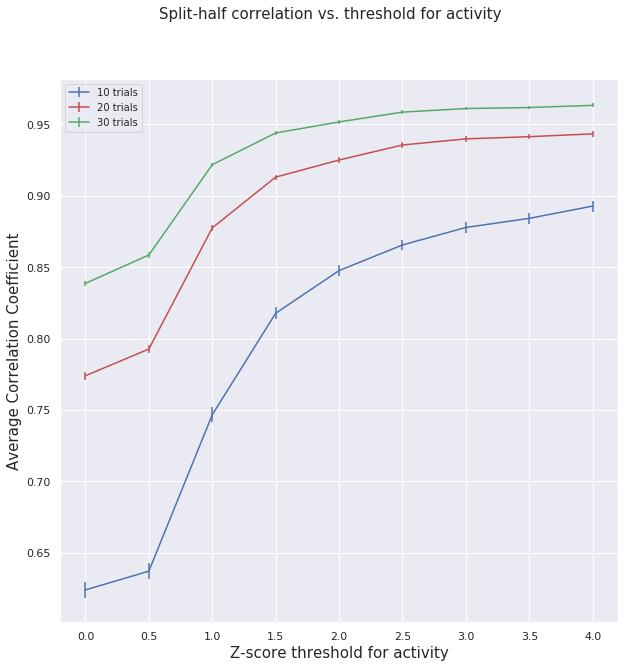

In [8]:
fig = plt.figure(figsize=(10,10))
plt.errorbar(thresh_list,R_mean[9,:],yerr=R_se[9,:],color = 'b')
plt.errorbar(thresh_list,R_mean[19,:],yerr=R_se[19,:],color = 'r')
plt.errorbar(thresh_list,R_mean[29,:],yerr=R_se[29,:],color = 'g')
plt.ylabel('Average Correlation Coefficient',fontsize = 15)
plt.xlabel('Z-score threshold for activity',fontsize = 15)
plt.suptitle('Split-half correlation vs. threshold for activity',fontsize = 15)
plt.legend(('10 trials','20 trials','30 trials'),fontsize = 10)
#plt.legend(('5 trials','10 trials','15 trials'),fontsize = 10)
#plt.legend(('4 trials','8 trials','12 trials'),fontsize = 10)
fig_fn = '20190705_JC097_split_half_correlation_vs_z_score_thresh_df_f.png'
#plt.savefig(os.path.join(responses_dir,'figures',fig_fn))

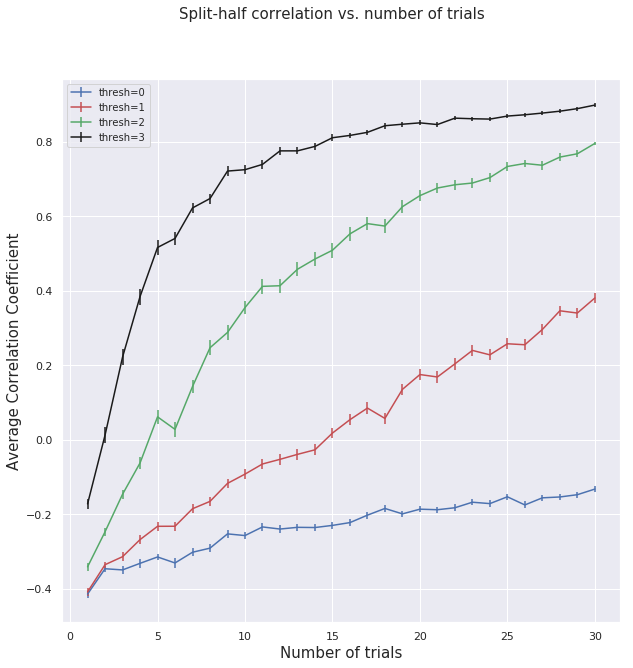

In [17]:
fig = plt.figure(figsize=(10,10))
plt.errorbar(split_size_list,R_mean[:,0],yerr=R_se[:,0],color = 'b')
plt.errorbar(split_size_list,R_mean[:,2],yerr=R_se[:,2],color = 'r')
plt.errorbar(split_size_list,R_mean[:,4],yerr=R_se[:,4],color = 'g')
plt.errorbar(split_size_list,R_mean[:,8],yerr=R_se[:,8],color = 'k')
plt.ylabel('Average Correlation Coefficient',fontsize = 15)
plt.xlabel('Number of trials',fontsize = 15)
plt.suptitle('Split-half correlation vs. number of trials',fontsize = 15)
plt.legend(('thresh=0','thresh=1','thresh=2','thresh=3'),fontsize = 10)
fig_fn = '20190705_JC097_split_half_correlation_vs_ntrials_df_f.png'
plt.savefig(os.path.join(responses_dir,'figures',fig_fn))

In [43]:
#get correlation for each cell individually
thresh_list = np.arange(0,4.5,0.5)
nreps = 100
split_size_list = np.arange(30)+1#np.array([4,8,12])
active_count= np.zeros((split_size_list.size,thresh_list.size,nreps))
R_mean_tmp = np.zeros((split_size_list.size,thresh_list.size,nreps))
R_max_tmp = np.zeros((split_size_list.size,thresh_list.size,nreps))
R_min_tmp = np.zeros((split_size_list.size,thresh_list.size,nreps))
R_cells = np.ones((split_size_list.size,thresh_list.size,nreps,nrois))*np.nan

for rep in range(nreps):
    for split_idx,split_size in enumerate(split_size_list):

        #randomly split
        rand_trials = np.random.permutation(ntrials)
        half1 = response_matrix[rand_trials[0:split_size]]
        half2 = response_matrix[rand_trials[split_size:(2*split_size)]]
        half1_zscore = zscore_matrix[rand_trials[0:split_size]]
        half2_zscore = zscore_matrix[rand_trials[split_size:(2*split_size)]]

        #get mean response across trials
        half1_mean = np.squeeze(np.mean(half1,0))
        half2_mean = np.squeeze(np.mean(half2,0))
        
        half1_zscore_mean = np.squeeze(np.mean(half1_zscore,0))
        half2_zscore_mean = np.squeeze(np.mean(half2_zscore,0))

        #get number of active cells - (threshold by z-score)
        for thresh_idx,thresh in enumerate(thresh_list):

            half1_rois = np.zeros((nrois,))
            
            for ridx in range(nrois):    
                if np.any(half1_zscore_mean[:,ridx]>thresh):
                    half1_rois[ridx] = 1
                    #get cell split-half correlation
                    R_tmp = np.corrcoef(np.squeeze(half1_mean[:,ridx]),np.squeeze(half2_mean[:,ridx]))
                    R_cells[split_idx,thresh_idx,rep,ridx] = R_tmp[0,1]
            active_rois = np.where(half1_rois)[0]
            active_count[split_idx,thresh_idx,rep] = len(active_rois)


            R_mean_tmp[split_idx,thresh_idx,rep] = np.nanmean(R_cells[split_idx,thresh_idx,rep,:],0)
            R_max_tmp[split_idx,thresh_idx,rep] = np.nanmax(R_cells[split_idx,thresh_idx,rep,:],0)
            R_min_tmp[split_idx,thresh_idx,rep] = np.nanmin(R_cells[split_idx,thresh_idx,rep,:],0)

/n/coxfs01/cechavarria/envs/suite2p/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice
/n/coxfs01/cechavarria/envs/suite2p/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: All-NaN slice encountered
/n/coxfs01/cechavarria/envs/suite2p/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: All-NaN slice encountered


In [44]:
R_mean = np.nanmean(R_mean_tmp,2)
R_max = np.nanmean(R_max_tmp,2)
R_min = np.nanmean(R_min_tmp,2)
R_se = np.true_divide(np.nanstd(R_mean_tmp,2),np.sqrt(nreps))

active_frac = active_count/nrois
active_frac_mean = np.mean(active_frac,2)
active_frac_se = np.true_divide(np.std(active_count,2),np.sqrt(nreps))

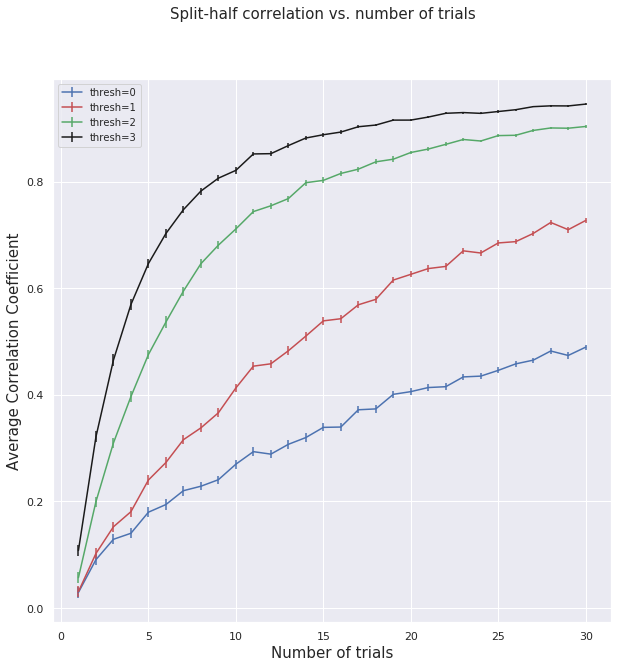

In [63]:
fig = plt.figure(figsize=(10,10))
plt.errorbar(split_size_list,R_mean[:,0],yerr=R_se[:,0],color = 'b')
plt.errorbar(split_size_list,R_mean[:,2],yerr=R_se[:,2],color = 'r')
plt.errorbar(split_size_list,R_mean[:,4],yerr=R_se[:,4],color = 'g')
plt.errorbar(split_size_list,R_mean[:,6],yerr=R_se[:,6],color = 'k')
plt.ylabel('Average Correlation Coefficient',fontsize = 15)
plt.xlabel('Number of trials',fontsize = 15)
plt.suptitle('Split-half correlation vs. number of trials',fontsize = 15)
plt.legend(('thresh=0','thresh=1','thresh=2','thresh=3'),fontsize = 10)
fig_fn = '20190705_JC097_avg_split_half_correlation_vs_ntrials_df_f.png'
#plt.savefig(os.path.join(responses_dir,'figures',fig_fn))

In [46]:
R_cells_mean = np.nanmean(R_cells,2)

/n/coxfs01/cechavarria/envs/suite2p/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


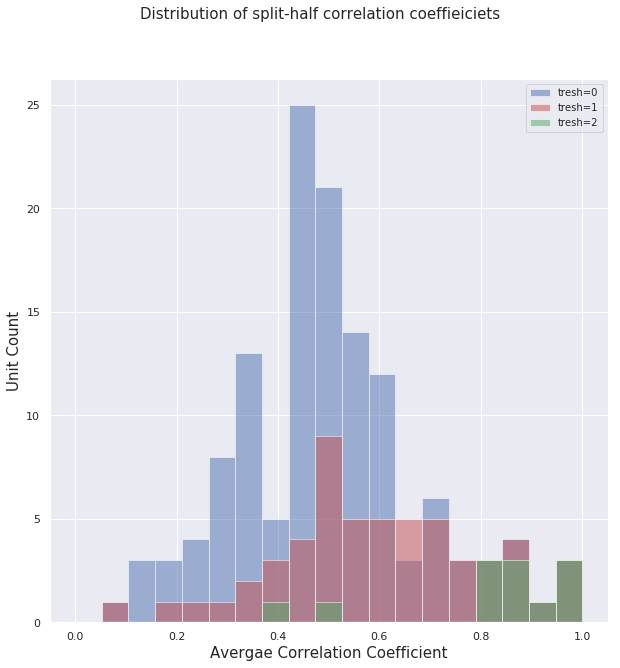

In [66]:
nbins = 20
bins = np.linspace(0,1,nbins)
fig = plt.figure(figsize=(10,10))
plt.hist(R_cells_mean[29,0,:],bins,alpha = 0.5, color = 'b',density=False,label='tresh=0')
plt.hist(R_cells_mean[29,2,:],bins,alpha = 0.5, color = 'r',density=False,label='tresh=1')
plt.hist(R_cells_mean[29,4,:],bins,alpha = 0.5, color = 'g',density=False,label='tresh=2')
plt.ylabel('Unit Count',fontsize = 15)
plt.xlabel('Avergae Correlation Coefficient',fontsize = 15)
plt.suptitle('Distribution of split-half correlation coeffieiciets',fontsize = 15)
plt.legend(fontsize = 10)
fig_fn = '20190705_JC097_avg_split_half_correlation_hist_count_df_f.png'
#plt.savefig(os.path.join(responses_dir,'figures',fig_fn))

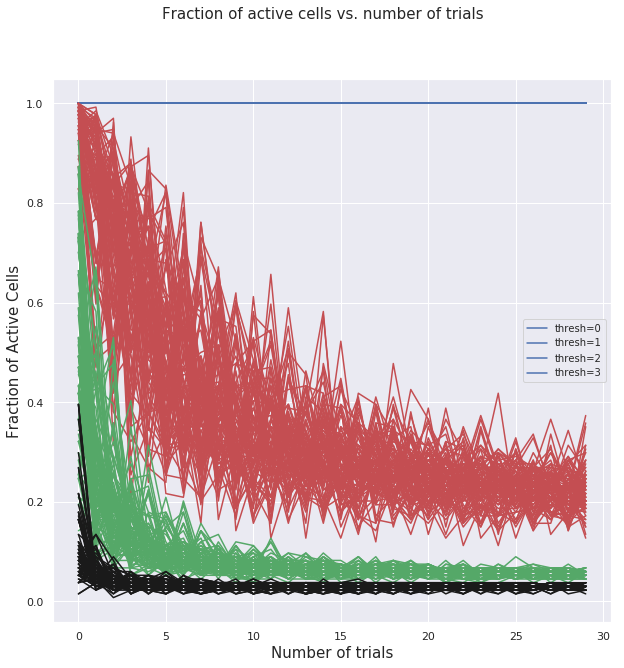

In [36]:
fig = plt.figure(figsize=(10,10))
plt.plot(active_frac[:,0],'b')
plt.plot(active_frac[:,2],'r')
plt.plot(active_frac[:,4],'g')
plt.plot(active_frac[:,8],'k')
plt.ylabel('Fraction of Active Cells',fontsize = 15)
plt.xlabel('Number of trials',fontsize = 15)
plt.suptitle('Fraction of active cells vs. number of trials',fontsize = 15)
plt.legend(('thresh=0','thresh=1','thresh=2','thresh=3'),fontsize = 10)

In [ ]:
thresh_list = np.arange(4)
nreps = 1
split_size_list = np.array([15])
split_idx = 0 
split_size = split_size_list[split_idx]
active_count= np.zeros((split_size_list.size,thresh_list.size,nreps))
R_matrix = np.zeros((split_size_list.size,thresh_list.size,nreps))
thresh_lifetime = np.zeros((nrois,))


for rep in range(nreps):

    #randomly split
    rand_trials = np.random.permutation(ntrials)
    half1 = response_matrix[rand_trials[0:split_size]]
    half2 = response_matrix[rand_trials[split_size:(2*split_size)]]
    half1_zscore = zscore_matrix[rand_trials[0:split_size]]
    half2_zscore = zscore_matrix[rand_trials[split_size:(2*split_size)]]

    #get mean response across trials
    half1_mean = np.squeeze(np.mean(half1,0))
    half2_mean = np.squeeze(np.mean(half2,0))

    half1_zscore_mean = np.squeeze(np.mean(half1_zscore,0))
    half2_zscore_mean = np.squeeze(np.mean(half2_zscore,0))

    #get number of active cells - (threshold by z-score)
    for thresh_idx,thresh in enumerate(thresh_list):

        half1_rois = np.zeros((nrois,))
        for ridx in range(nrois):    
            if np.any(half1_zscore_mean[:,ridx]>thresh):
                half1_rois[ridx] = 1
                thresh_lifetime[ridx] = thresh
        active_rois = np.where(half1_rois)[0]
        active_count[split_idx,thresh_idx,rep] = len(active_rois)

        half1_mean_sub = half1_mean[:,active_rois].flatten()
        half2_mean_sub = half2_mean[:,active_rois].flatten()

        R_mat = np.corrcoef(half1_mean_sub,half2_mean_sub)
        R_matrix[split_idx,thresh_idx,rep] = R_mat[0,1]

In [ ]:
thresh_lt_array = np.zeros(half1_mean.shape)

for ridx in range(nrois):
    thresh_lt_array[:,ridx] = thresh_lifetime[ridx] 

In [ ]:
half1_mean_all = half1_mean.flatten()
half2_mean_all = half2_mean.flatten()
thresh_all = thresh_lt_array.flatten()


In [ ]:
thresh_all[idx]

In [ ]:
c_mat = ['b','r','g','k']
fig = plt.figure(figsize=(10,10))
for idx in range(half1_mean.size):
    plt.scatter(half1_mean_all[idx],half2_mean_all[idx],color = c_mat[int(thresh_all[idx])])
plt.ylabel('Df/F',fontsize = 15)
plt.xlabel('Df/F',fontsize = 15)
plt.suptitle('Split-half correlation',fontsize = 15)
#plt.legend(('thresh=0','thresh=1','thresh=2','thresh=3'),fontsize = 10)


fig_fn = '20190621_JC097_sample_split_half_correlation_max_thresh_color.png'
plt.savefig(os.path.join(responses_dir,'figures',fig_fn))

In [ ]:
thresh_list = np.arange(0.5,4.5,0.5)
nreps = 100
split_size_list = np.array([15])
split_idx = 0 
split_size = split_size_list[split_idx]

half1_count = np.zeros((split_size_list.size,thresh_list.size,nreps))
overlap_count = np.zeros((split_size_list.size,thresh_list.size,nreps))
in1_or2_count = np.zeros((split_size_list.size,thresh_list.size,nreps))
in1_only_count = np.zeros((split_size_list.size,thresh_list.size,nreps))
in2_only_count = np.zeros((split_size_list.size,thresh_list.size,nreps))

active_count= np.zeros((split_size_list.size,thresh_list.size,nreps))


for rep in range(nreps):

    #randomly split
    rand_trials = np.random.permutation(ntrials)
    half1 = response_matrix[rand_trials[0:split_size]]
    half2 = response_matrix[rand_trials[split_size:(2*split_size)]]
    half1_zscore = zscore_matrix[rand_trials[0:split_size]]
    half2_zscore = zscore_matrix[rand_trials[split_size:(2*split_size)]]

    #get mean response across trials
    half1_zscore_mean = np.squeeze(np.mean(half1_zscore,0))
    half2_zscore_mean = np.squeeze(np.mean(half2_zscore,0))

    #get number of active cells - (threshold by z-score)
    for thresh_idx,thresh in enumerate(thresh_list):

        half1_rois = np.zeros((nrois,))
        half2_rois = np.zeros((nrois,))
        for ridx in range(nrois):    
            if np.any(half1_zscore_mean[:,ridx]>thresh):
                half1_rois[ridx] = 1
            if np.any(half2_zscore_mean[:,ridx]>thresh):
                half2_rois[ridx] = 1
        active_rois1 = np.where(half1_rois)[0].tolist()
        active_rois2 = np.where(half2_rois)[0].tolist()
        
        overlap_count[split_idx,thresh_idx,rep] = len(list(set(active_rois1) & set(active_rois2)))
        in1_or2_count[split_idx,thresh_idx,rep] = np.unique(np.array(active_rois1 + active_rois2)).size
        
#         if len(np.where(half1_rois))>0:
#             in1_only[split_idx,thresh_idx,rep] = np.sum(1-half2_rois[np.where(half1_rois)[0]])
            
#         active_count[split_idx,thresh_idx,rep] = len(active_rois)

#         half1_mean_sub = half1_mean[:,active_rois].flatten()
#         half2_mean_sub = half2_mean[:,active_rois].flatten()

#         R_mat = np.corrcoef(half1_mean_sub,half2_mean_sub)
#         R_matrix[split_idx,thresh_idx,rep] = R_mat[0,1]

In [ ]:
tmp = 
print(tmp)

In [ ]:
np.where(half1_rois)[0]

In [ ]:
mean_overlap = np.squeeze(np.mean(overlap_count,2))
mean_overlap_frac = np.squeeze(np.mean(np.true_divide(overlap_count,in1_or2_count),2))
mean_count = np.squeeze(np.mean(in1_or2_count,2))

In [ ]:
plt.plot(thresh_list,mean_overlap,'b')
plt.plot(thresh_list,mean_count,'g')

In [ ]:
plt.plot(thresh_list,mean_overlap_frac,'b')

In [ ]:
print(len(active_rois1))
print(active_rois1)
print(len(active_rois2))
print(active_rois2)
print(len(list(set(active_rois1) & set(active_rois2))))
print(list(set(active_rois1) & set(active_rois2)))
print(len(list(set(active_rois1) - set(active_rois2))))
print(list())

In [ ]:
set(active_rois1) - set(active_rois2)

In [ ]:
response_matrix_zscore.shape

In [ ]:
R_mean = np.mean(R_matrix,1)
R_se = np.true_divide(np.nanstd(R_matrix,1),np.sqrt(nreps))

plt.errorbar(thresh_list,R_mean,yerr=R_se)

In [ ]:
frac_overlap_mean = np.mean(frac_overlap,1)
half1_count_mean = np.mean(half1_count,1)/nrois
half2_count_mean = np.mean(half2_count,1)/nrois

In [ ]:
plt.plot(thresh_list,frac_overlap_mean,'b')

#
plt.plot(thresh_list,half1_count_mean,'r')
plt.plot(thresh_list,half2_count_mean,'g')

In [ ]:

nreps = 10000




